<a href="https://colab.research.google.com/github/n3d1m/SYDE-677-Final-Project/blob/main/ImageNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
# Imports
import zipfile
import os
import cv2
import numpy as np
from matplotlib.pyplot import figure, imshow, axis, show, plot, xlim, ylim, hist, subplots, tight_layout
from matplotlib.image import imread
from PIL import Image
from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms

In [2]:
!rm -r sample_data/
!rm -r china_set/
!rm -r montgomery_set/
!rm -r china_set_test/
!rm -r montgomery_set_test/

!mkdir china_set
!mkdir montgomery_set
!mkdir china_set_test
!mkdir montgomery_set_test

rm: cannot remove 'china_set/': No such file or directory
rm: cannot remove 'montgomery_set/': No such file or directory
rm: cannot remove 'china_set_test/': No such file or directory
rm: cannot remove 'montgomery_set_test/': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def unzip_images(zip_location, extraction_location):
  with zipfile.ZipFile(zip_location, 'r') as zip_ref:
    zip_ref.extractall(extraction_location)

In [5]:
china_set_path = '/content/drive/MyDrive/SYDE 677 Final Project/Images/ChinaSet_AllFiles.zip'
china_set_extraction_location = '/content/china_set'

montgomery_set_path = '/content/drive/MyDrive/SYDE 677 Final Project/Images/Montgomery.zip'
montgomery_set_extraction_location = '/content/montgomery_set'

unzip_images(china_set_path,china_set_extraction_location)
unzip_images(montgomery_set_path, montgomery_set_extraction_location)


In [36]:
def showImagesHorizontally(images_shown, image_directory, title):

    list_of_files = os.listdir(image_directory)
    if 'Thumbs.db' in list_of_files:
      list_of_files.remove('Thumbs.db')

    fig = figure(figsize=(20,20))
    fig.suptitle(title,y=0.6)

    loop_range = len(list_of_files) if len(list_of_files) < images_shown else images_shown

    for i in range(loop_range):
      a=fig.add_subplot(1,images_shown,i+1)
      image = imread(image_directory + list_of_files[i])
      imshow(image,cmap='Greys_r')
      axis('off')
     
      

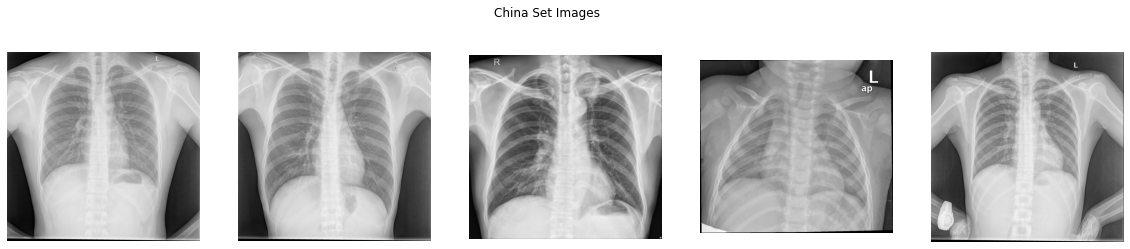

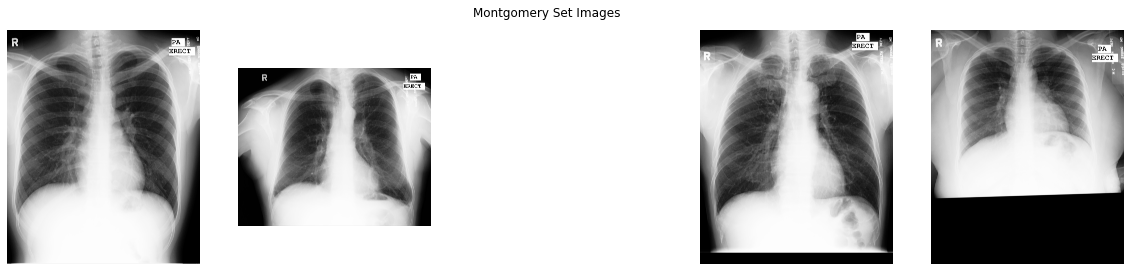

In [19]:
china_set_image_directory = china_set_extraction_location + '/ChinaSet_AllFiles/CXR_png/'
montgomery_set_image_directory = montgomery_set_extraction_location + '/MontgomerySet/CXR_png/'

showImagesHorizontally(5,china_set_image_directory, 'China Set Images')
showImagesHorizontally(5,montgomery_set_image_directory, 'Montgomery Set Images')


In [20]:
def crop_background(image_directory, save_directory, is_test):

  list_of_files = os.listdir(image_directory)
  loop_range = 5 if is_test else len(list_of_files)
  

  for i in range(loop_range): 

    if(list_of_files[i] != 'Thumbs.db'): # there is a .db file at the end of each image directory that needs to be avoided
      img = cv2.imread(image_directory + list_of_files[i])
      img = cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX) # normalize image to pixel values between 0 and 255 - needed for thresholding 
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # threshold 
      thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
      hh, ww = thresh.shape

      # make bottom 2 rows black where they are white the full width of the image
      thresh[hh-3:hh, 0:ww] = 0

      # get bounds of white pixels
      white = np.where(thresh==255)
      xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

      # crop the image at the bounds adding back the two blackened rows at the bottom
      crop = img[ymin:ymax+3, xmin:xmax]

      # save resulting masked image
      #cv2.imwrite('xray_chest_thresh.jpg', thresh)
      cv2.imwrite(save_directory + list_of_files[i], crop)

In [26]:
china_set_test_directory = '/content/china_set_test/'
montgomery_set_test_directory = '/content/montgomery_set_test/'

crop_background(china_set_image_directory, china_set_test_directory, True)
crop_background(montgomery_set_image_directory, montgomery_set_test_directory, True)

5 ['CHNCXR_0135_0.png', 'CHNCXR_0183_0.png', 'CHNCXR_0332_1.png', 'CHNCXR_0075_0.png', 'CHNCXR_0156_0.png']
5 ['MCUCXR_0051_0.png', 'MCUCXR_0083_0.png', 'MCUCXR_0387_1.png', 'MCUCXR_0053_0.png']


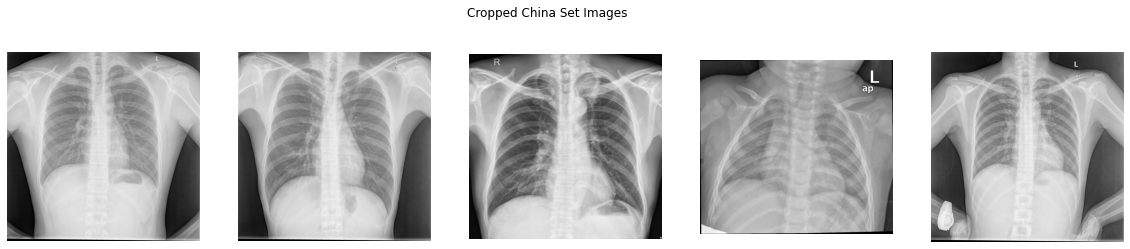

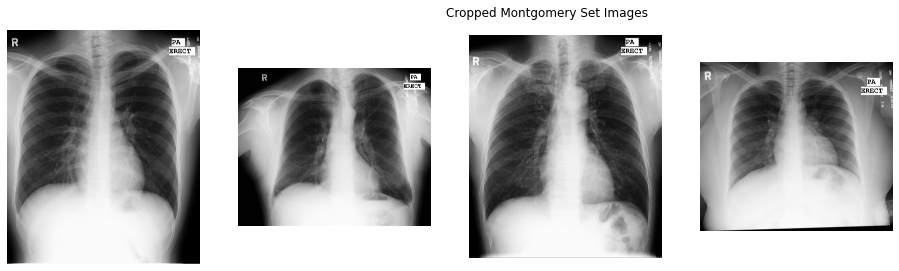

In [37]:
showImagesHorizontally(5, china_set_test_directory, 'Cropped China Set Images')
showImagesHorizontally(5, montgomery_set_test_directory, 'Cropped Montgomery Set Images')

In [38]:
# scrap this for now

def preprocess_images(image_directory):
  images = os.listdir(image_directory)

  try:
    images.remove('.ipynb_checkpoints')
  except:
    None

  for i in range(len(images)):

    img = Image.open(image_directory + images[i])

    print(img.format)
    print(img.mode)
    print(img.size)
    
    pixels = np.asarray(img)
    pixels = pixels.astype('float32')

    print('Data Type: %s' % pixels.dtype)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

    # Global standardization of pixels
    mean, std = pixels.mean(), pixels.std()
    pixels = (pixels - mean) / std

    # normalizing image between 0 and 1
    # norm_image = pixels / 255
    

    pixels.save(image_directory + 'image_' + str(i) + '.png') #images need to be saved as jpegs - pngs will be displayed as black when normalized from 0-1

In [39]:
# Move this step to the end of the pipeline

#preprocess_images(china_set_test_directory)
#preprocess_images(montgomery_set_test_directory)

# showImagesHorizontally(5, china_set_test_directory, 'Preprocessed China Set Images')
# showImagesHorizontally(5, montgomery_set_test_directory, 'Preprocessed Montgomery Set Images')

In [110]:
def display_image_histogram(image_directory):

  images = os.listdir(image_directory)
  fig = figure()

  for i in range(len(images)):

    img = cv2.imread(image_directory + images[i])
    vals = img.mean(axis=2).flatten()

    b, bins, patches = hist(vals, 255)
    print(b.max())
    xlim([0,255])
    ylim([0,150000])
    show()
    # imshow(image,cmap='Greys_r')
    # axis('off')


138194.0


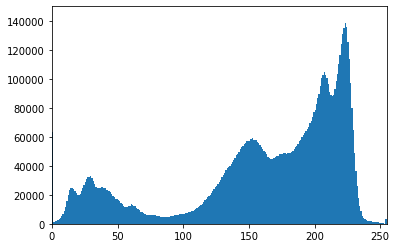

102792.0


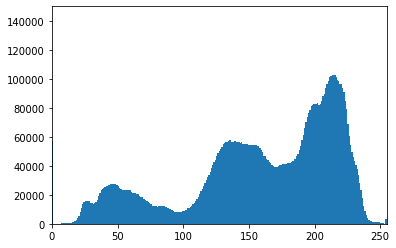

103453.0


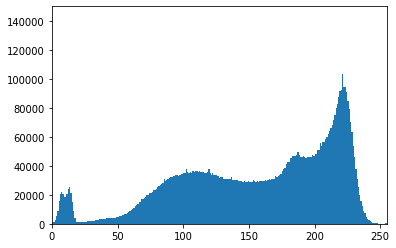

21381.0


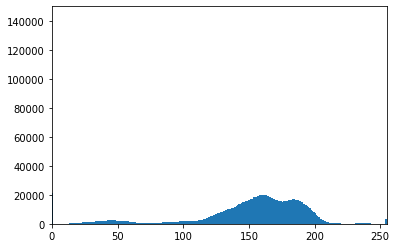

124838.0


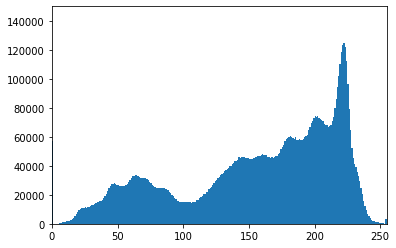

In [111]:
display_image_histogram(china_set_test_directory)

953168.0


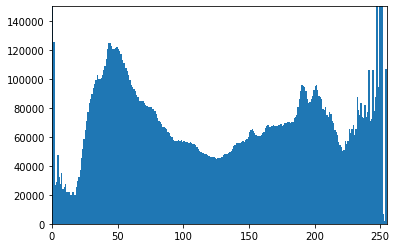

1245918.0


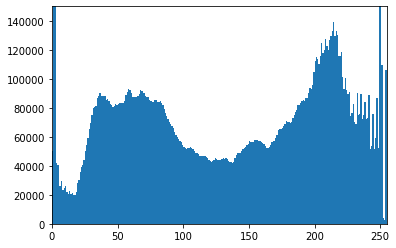

711521.0


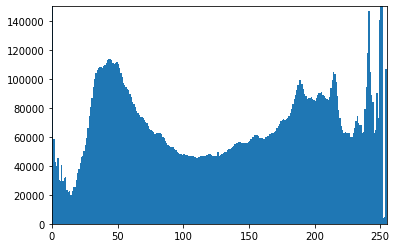

241579.0


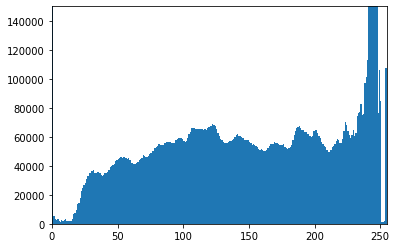

In [112]:
display_image_histogram(montgomery_set_test_directory)

(1500, 1500, 3) (1500, 1500, 3)


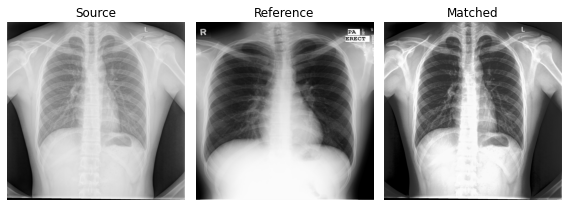

In [71]:
# testing histogram matching

ref_list = os.listdir(china_set_test_directory)
image_list = os.listdir(montgomery_set_test_directory)

image = cv2.imread(china_set_test_directory + ref_list[0])
reference = cv2.imread(montgomery_set_test_directory + image_list[0])

image_size = (1500,1500)

reference = cv2.resize(reference, dsize=image_size, interpolation=cv2.INTER_CUBIC)
image = cv2.resize(image, dsize=image_size, interpolation=cv2.INTER_CUBIC)

print(reference.shape, image.shape)

matched = match_histograms(image, reference, multichannel=True)

fig, (ax1, ax2, ax3) = subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
  aa.set_axis_off()

ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')
ax3.imshow(matched)
ax3.set_title('Matched')

tight_layout()
show()


True

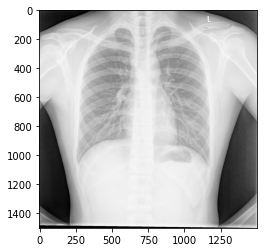

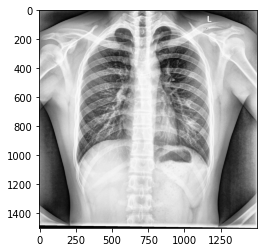

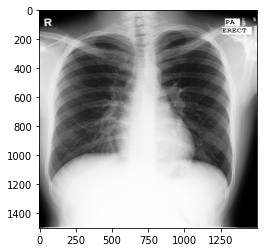

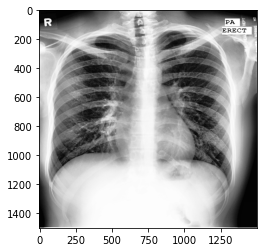

In [98]:
# Playing with contrast settings

!rm -r clahe_test/
!mkdir clahe_test
ref_list = os.listdir(china_set_test_directory)
image_list = os.listdir(montgomery_set_test_directory)

image = cv2.imread(china_set_test_directory + ref_list[0])
reference = cv2.imread(montgomery_set_test_directory + image_list[0])

image_size = (1500,1500)

reference = cv2.resize(reference, dsize=image_size, interpolation=cv2.INTER_CUBIC)
image = cv2.resize(image, dsize=image_size, interpolation=cv2.INTER_CUBIC)

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
reference = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit = 3)

image_clahe = clahe.apply(image)
reference_clahe = clahe.apply(reference)

figure()
imshow(image,cmap='Greys_r')

figure()
imshow(image_clahe,cmap='Greys_r')

figure()
imshow(reference,cmap='Greys_r')

figure()
imshow(reference_clahe,cmap='Greys_r')

cv2.imwrite('clahe_test/image1.png', image_clahe)
cv2.imwrite('clahe_test/image2.png', reference_clahe)


# imshow("Orginal Reference", reference)
# imshow("CLAHE Reference", reference_clahe)

99751.0


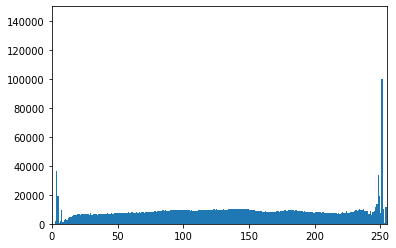

16136.0


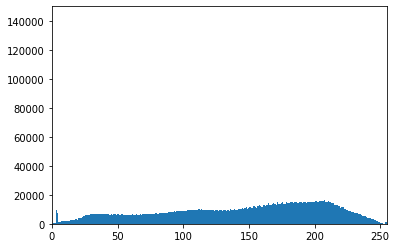

In [113]:
display_image_histogram('clahe_test/')